In [ ]:
import math

import torch
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
type_1 = torch.zeros(128, 1, 1000)  # 10个样本，每个样本 1×100
# type_2 = torch.ones(10, 1, 12)
# labels = F.one_hot(torch.tensor([0,0,0,0,0,0,0,0,0,0]))

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2)
                             * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [ ]:
class VATN(nn.Module):
    def __init__(self, ):
        super(VATN, self).__init__()
        self.conv = nn.Conv1d(in_channels=1, out_channels=256, kernel_size=50, stride=25)
        self.pos_encoder = PositionalEncoding(256)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=256, nhead=8, dim_feedforward=1024, batch_first=True),
            num_layers=8)
        self.max_pool = nn.AdaptiveMaxPool1d(4)
        self.avg_pool = nn.AdaptiveAvgPool1d(4)
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(312, 64)
        self.fc_2 = nn.Linear(64, 4)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = self.conv(x)
        x = x.transpose(1, 2)
        x = self.pos_encoder(x)
        x = self.encoder(x)
        x_1 = self.max_pool(x)
        x_2 = self.avg_pool(x) 
        x = torch.cat((x_1, x_2), dim=2)
        x = self.flatten(x)
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        x = self.softmax(x)
        return x

In [ ]:
model = VATN()
out = model(type_1)
out.shape

In [ ]:
from utils.model import VATN

In [ ]:
model = VATN()
out = model(type_1)
out.shape

In [ ]:
from utils.preprocess import preprocess_data, JNUDataset

In [ ]:
BATCH_SIZE = 128
DATA_PATH = 'data'

In [ ]:
train_loader = DataLoader(JNUDataset(DATA_PATH, is_train=False, device=device), batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
model = VATN()
model.to(device)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
def train(model, num_epochs=500):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    loss_history = []
    for epoch in range(num_epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            # data = data.to(device)
            # target = target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.to(torch.float32))
            loss.backward()
            optimizer.step()
            
            # if batch_idx % 8 == 0:
            #     # print(output)
            #     # print(target.shape)
            #     print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
            #             f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
        if epoch == num_epochs-1:
            print(output)
            print(target)
                
        loss_history.append(loss.item())
    print('Finished Training')
    plt.plot(loss_history)
    # return loss_history

tensor([[3.3164e-05, 9.6510e-08, 1.5937e-07, 9.9997e-01],
        [5.1780e-04, 4.5528e-07, 7.4430e-08, 9.9948e-01],
        [1.6480e-09, 1.0000e+00, 2.7571e-11, 2.3711e-06],
        [6.9796e-12, 7.6207e-06, 9.9059e-01, 9.4051e-03],
        [9.7599e-01, 2.2462e-02, 3.4644e-15, 1.5493e-03],
        [4.6042e-10, 1.0000e+00, 1.6021e-12, 6.9550e-07],
        [1.0944e-08, 2.0662e-02, 2.4357e-02, 9.5498e-01],
        [9.9859e-01, 1.0997e-03, 7.3698e-17, 3.0841e-04],
        [7.2093e-06, 6.0008e-08, 1.9974e-07, 9.9999e-01],
        [1.8150e-14, 1.0000e+00, 6.8352e-10, 1.8298e-07],
        [4.9475e-05, 1.4560e-07, 2.4327e-07, 9.9995e-01],
        [1.3307e-01, 4.3374e-03, 1.3017e-08, 8.6260e-01],
        [3.8276e-25, 3.8722e-10, 1.0000e+00, 7.1250e-13],
        [2.0464e-03, 9.9777e-01, 5.2233e-14, 1.8096e-04],
        [4.2565e-06, 5.9831e-05, 9.4585e-08, 9.9994e-01],
        [8.4369e-06, 9.9998e-01, 5.1375e-14, 1.5557e-05],
        [9.9871e-06, 4.2516e-08, 6.2008e-08, 9.9999e-01],
        [1.418

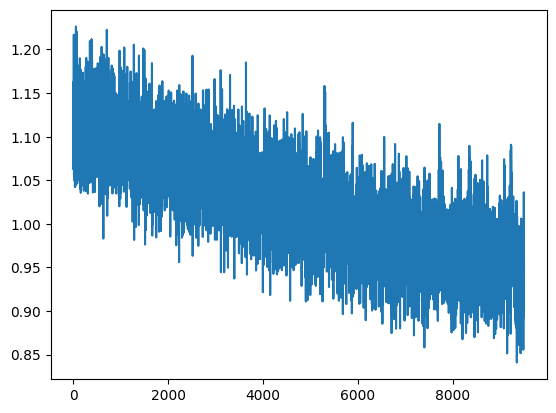

In [37]:
train(model)